# Profile HMM of the HIV pol region

### Download and metadata on gag-pol protein

In [5]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from Bio import SearchIO


In [ ]:
# search for the HIV gag-pol protein in uniprot search
base = "https://rest.uniprot.org/uniprotkb/search"
params = {
    "query": "gag-pol AND reviewed:true AND taxonomy_id:11676",  # taxo: 11676 is for HIV Type 1 (similar to the previous HO)
    "format": "tsv",
    "size": 100
}

In [19]:
try:
    response = requests.get(base, params=params)
    response.raise_for_status()
    metadata_tsv = response.text

    with open("gag_pol_prot.tsv", "w") as f:
        f.write(metadata_tsv)

    accessions = [
        line.split('\t')[0] # grabs first column which is the accession number
        for line in metadata_tsv.strip().split('\n')[1:] # skippu the header line
    ]

    if accessions:
        fasta_url = "https://rest.uniprot.org/uniprotkb/stream"
        fasta_params = {
            "format": "fasta",
            "query": " OR ".join([f"accession:{acc}" for acc in accessions])
        }
        fasta_response = requests.get(fasta_url, params=fasta_params)
        fasta_response.raise_for_status()
        with open("gag_pol_prot.fasta", "w") as f:
            f.write(fasta_response.text)

        print(f"Download complete: {len(accessions)} sequences saved.")
    else:
        print("No accession numbers found in metadata.")

except requests.exceptions.RequestException as e:
    print(f" An error occurred: {e}")


Download complete: 79 sequences saved.


In [22]:
metadata_gag_pol = pd.read_csv("gag_pol_prot.tsv", sep="\t")
metadata_gag_pol.head()

,Entry,Entry Name,Reviewed,Protein names,Gene Names,Organism,Length
0,P12498,POL_HV1J3,reviewed,Gag-Pol polyprotein (Pr160Gag-Pol) [Cleaved in...,gag-pol,Human immunodeficiency virus type 1 group M su...,532
1,P05960,POL_HV1C4,reviewed,Gag-Pol polyprotein (Pr160Gag-Pol) [Cleaved in...,gag-pol,Human immunodeficiency virus type 1 group M su...,550
2,P18802,POL_HV1ND,reviewed,Gag-Pol polyprotein (Pr160Gag-Pol) [Cleaved in...,gag-pol,Human immunodeficiency virus type 1 group M su...,1432
3,P03367,POL_HV1BR,reviewed,Gag-Pol polyprotein (Pr160Gag-Pol) [Cleaved in...,gag-pol,Human immunodeficiency virus type 1 group M su...,1447
4,O12158,POL_HV192,reviewed,Gag-Pol polyprotein (Pr160Gag-Pol) [Cleaved in...,gag-pol,Human immunodeficiency virus type 1 group M su...,1431


In [ ]:
# parse through the subtypes in organism column, search for subtype in string
subtypes = metadata_gag_pol["Organism"].str.extract(r'\((.*?)\)')[0].unique()

In [45]:
metadata_gag_pol[['group', 'subtype', 'isolate']] = metadata_gag_pol['Organism'].str.extract(r"group ([A-Z])(?: subtype ([A-Z0-9]+))? \((?:isolate|strain) ([^)]+)\)")

In [46]:
metadata_gag_pol["subtype"] = metadata_gag_pol["subtype"].fillna("None")

In [44]:
organisms = metadata_gag_pol["Organism"].unique()

with open ("gag_pol_prot_organisms.txt", "w") as f:
    for organism in organisms:
        f.write(organism + "\n")

In [52]:
# rows that have no subtype
no_subtype = metadata_gag_pol[metadata_gag_pol["subtype"] == "A"]
no_subtype

,Entry,Entry Name,Reviewed,Protein names,Gene Names,Organism,Length,group,subtype,isolate
6,P04588,POL_HV1MA,reviewed,Gag-Pol polyprotein (Pr160Gag-Pol) [Cleaved in...,gag-pol,Human immunodeficiency virus type 1 group M su...,1440,M,A,MAL
23,P24740,POL_HV1U4,reviewed,Gag-Pol polyprotein (Pr160Gag-Pol) [Cleaved in...,gag-pol,Human immunodeficiency virus type 1 group M su...,1428,M,A,U455
52,P24736,GAG_HV1U4,reviewed,Gag polyprotein (Pr55Gag) [Cleaved into: Matri...,gag,Human immunodeficiency virus type 1 group M su...,493,M,A,U455
59,P04594,GAG_HV1MA,reviewed,Gag polyprotein (Pr55Gag) [Cleaved into: Matri...,gag,Human immunodeficiency virus type 1 group M su...,505,M,A,MAL


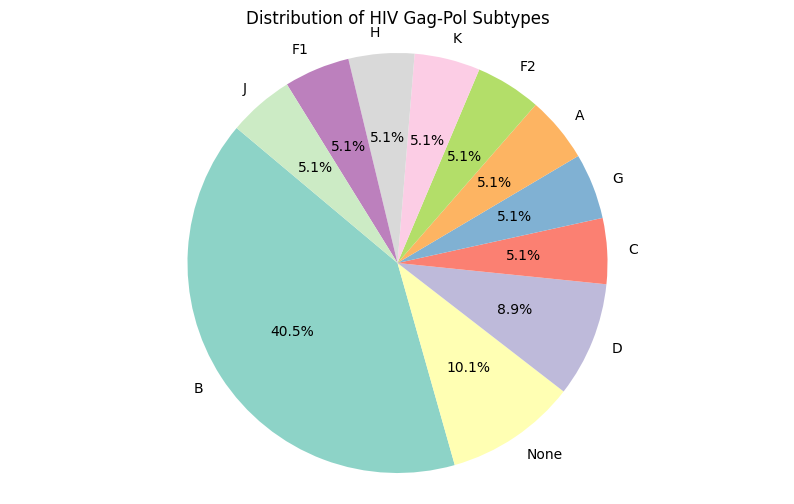

In [47]:
# Do a pie chart of the subtypes
plt.figure(figsize=(10, 6))
plt.pie(metadata_gag_pol["subtype"].value_counts(), 
        labels=metadata_gag_pol["subtype"].value_counts().index, 
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette("Set3", n_colors=len(metadata_gag_pol["subtype"].unique())))
plt.title("Distribution of HIV Gag-Pol Subtypes")
plt.axis('equal')
plt.show()

In [54]:
metadata_gag_pol.sort_values(by = ["subtype", "group"], inplace=True)

In [ ]:
# Choose 2 for each subtype, or 2 for each group if no subtype, then save to a new fasta file, just get from the fasta file we already have
selected_sequences = []
for subtype in metadata_gag_pol["subtype"].unique():
    subtype_sequences = metadata_gag_pol[metadata_gag_pol["subtype"] == subtype].head(2)
    selected_sequences.extend(subtype_sequences["Entry"].tolist())
    # if subtype is "None", just take the first 2 sequences from that group
    if subtype == "None":
        subtype_sequences = metadata_gag_pol[metadata_gag_pol["subtype"] == "None"]
        for group in subtype_sequences["group"].unique():
            group_sequences = subtype_sequences[subtype_sequences["group"] == group].head(2)
            selected_sequences.extend(group_sequences["Entry"].tolist())

# get the fasta sequences from the fasta file
fasta_sequences = []
with open("gag_pol_prot.fasta", "r") as f:
    write_sequence = False
    for line in f:
        if line.startswith(">"):
            if any(seq in line for seq in selected_sequences):
                write_sequence = True
                fasta_sequences.append(line.strip())
            else:
                write_sequence = False
        elif write_sequence:
            fasta_sequences[-1] += "\n" + line.strip()

with open("selected_gag_pol_prot.fasta", "w") as f:
    for seq in fasta_sequences:
        f.write(seq + "\n")



### Multiple Sequence Alignment

In [1]:
!mafft --auto selected_gag_pol_prot.fasta > gag_pol_aln.fasta

outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
rescale = 1
All-to-all alignment.
tbfast-pair (aa) Version 7.525
alg=L, model=BLOSUM62, 2.00, -0.10, +0.10, noshift, amax=0.0
0 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   20 / 24
done.

Progressive alignment ... 
STEP    21 /23 
Reallocating..done. *alloclen = 3910
STEP    23 /23 
done.
tbfast (aa) Version 7.525
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
1 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 0
randomseed = 0
blosum 62 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
rescale = 1

   20 / 24
Segment   1/  1    1-1486
STEP 003-015-1  identical.    identical.    identical.    identical.    identical.    identical.    identical.    identical.    identical.    identical.   

### Building HMM

In [2]:
!hmmbuild -n gag_pol gag_pol.hmm gag_pol_aln.fasta

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.1b2 (February 2015); http://hmmer.org/
# Copyright (C) 2015 Howard Hughes Medical Institute.
# Freely distributed under the GNU General Public License (GPLv3).
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             gag_pol_aln.fasta
# output HMM file:                  gag_pol.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     gag_pol_aln             24  1484  1434     0.47  0.590 

# CPU time: 0.55u 0.02s 00:00:00.57 Elapsed: 00:00:00.63


### Preprocessing HIV Patient FASTQ Data

Used only forward read

In [2]:
!seqtk seq -a SRR4089868_1.fastq > SRR4089868.fasta

In [4]:
!transeq -sequence SRR4089868.fasta -outseq SRR4089868_prot.fasta -frame 6

Translate nucleic acid sequences


In [3]:
!hmmsearch --domtblout SRR4089868.domtblout -o SRR4089868.txt gag_pol.hmm SRR4089868_prot.fasta

In [ ]:
!hmmsearch -E 1E-5 --domtblout SRR4089868_1e5.domtblout gag_pol.hmm SRR4089868_prot.fasta

In [6]:
def parse_domtblout(domtblout_file):
    data = []
    for query_result in SearchIO.parse(domtblout_file, 'hmmsearch3-domtab'):
        # print (query_result)
        for hit in query_result:
            for hsp in hit.hsps:
                data.append({
                    "query_id": query_result.id,
                    "hit_id": hit.id,
                    "evalue": hit.evalue,
                    "bitscore": hit.bitscore,
                    "description": hit.description, 
                    "bias": hit.bias,
                    "hmm_seq_length": hit.seq_len,
                    "best_doman_bias": hsp.bias,
                    "cevalue": hsp.evalue_cond,
                    "ievalue": hsp.evalue,
                    "best_domain_bitscore": hsp.bitscore,
                    "hit_strand": hsp.hit_strand,
                    "hit_start": hsp.hit_start,
                    "hit_end": hsp.hit_end,
                    "query_strand": hsp.query_strand,
                    "query_start": hsp.query_start,
                    "query_end": hsp.query_end
                })
    return data

In [7]:
seq_hits = parse_domtblout ("SRR4089868.domtblout")
seq_hits_df = pd.DataFrame(seq_hits)

In [9]:
seq_best_hits_df = seq_hits_df.loc[seq_hits_df.groupby('hit_id')['ievalue'].idxmin()]
seq_best_hits_df = seq_best_hits_df.sort_values(by=['hit_id', 'ievalue'])
seq_best_hits_df = seq_best_hits_df.reset_index(drop=True)
seq_best_hits_df.head(10)

,query_id,hit_id,evalue,bitscore,description,bias,hmm_seq_length,best_doman_bias,cevalue,ievalue,best_domain_bitscore,hit_strand,hit_start,hit_end,query_strand,query_start,query_end
0,gag_pol_aln,SRR4089868.10000_5,1.600000e-18,70.7,10000 length=240,0.0,80,0.0,2.900000e-19,1.700000e-18,70.6,0,1,79,0,432,503
1,gag_pol_aln,SRR4089868.10001_6,1.600000e-48,170.1,10001 length=251,0.1,84,0.1,3.000000e-49,1.700000e-48,170.0,0,0,83,0,712,795
2,gag_pol_aln,SRR4089868.10002_2,8.500000e-52,181.0,10002 length=249,0.2,83,0.2,1.600000e-52,9.300000e-52,180.8,0,0,83,0,622,705
3,gag_pol_aln,SRR4089868.10003_6,2.500000e-43,152.9,10003 length=251,1.1,84,1.1,4.600000e-44,2.700000e-43,152.8,0,0,83,0,498,581
4,gag_pol_aln,SRR4089868.10004_4,4.700000e-32,115.6,10004 length=249,0.1,83,0.1,8.300000e-33,4.800000e-32,115.5,0,3,83,0,465,541
5,gag_pol_aln,SRR4089868.10005_6,1.500000e-49,173.5,10005 length=251,2.4,84,2.4,2.800000e-50,1.600000e-49,173.4,0,0,84,0,577,661
6,gag_pol_aln,SRR4089868.10006_4,7.300000e-45,158.0,10006 length=235,0.1,78,0.1,1.300000e-45,7.900000e-45,157.9,0,0,78,0,719,797
7,gag_pol_aln,SRR4089868.10007_4,3.400000e-51,179.0,10007 length=251,0.1,83,0.1,6.400000e-52,3.700000e-51,178.8,0,0,83,0,670,753
8,gag_pol_aln,SRR4089868.10008_3,2.000000e-37,133.4,10008 length=200,0.1,66,0.1,3.700000e-38,2.100000e-37,133.2,0,0,66,0,723,789
9,gag_pol_aln,SRR4089868.10009_6,1.400000e-47,167.0,10009 length=251,4.1,84,4.1,2.700000e-48,1.600000e-47,166.8,0,0,84,0,523,607


In [18]:
# extract the read_id from the hit_id SRR4089868.81140_2 ->SRR4089868.81140
seq_best_hits_df["read_id"] = seq_best_hits_df["hit_id"].str.split("_").str[0]

In [19]:
# get rows with multiple hits but same read_id, if multiplpe hits, take the one with the lowest evalue, store it same df
seq_best_read_df = seq_best_hits_df.loc[seq_best_hits_df.groupby('read_id')['ievalue'].idxmin()]
seq_best_read_df = seq_best_read_df.sort_values(by=['read_id', 'ievalue'])
seq_best_read_df = seq_best_read_df.reset_index(drop=True)
seq_best_read_df.head(10)

,query_id,hit_id,evalue,bitscore,description,bias,hmm_seq_length,best_doman_bias,cevalue,ievalue,best_domain_bitscore,hit_strand,hit_start,hit_end,query_strand,query_start,query_end,read_id
0,gag_pol_aln,SRR4089868.1_2,1.900000e-17,67.1,1 length=149,0.1,50,0.1,3.500000e-18,2.100000e-17,67.0,0,0,49,0,745,794,SRR4089868.1
1,gag_pol_aln,SRR4089868.10_5,2.100000e-45,159.8,10 length=249,0.6,83,0.6,3.900000e-46,2.300000e-45,159.7,0,0,82,0,509,591,SRR4089868.10
2,gag_pol_aln,SRR4089868.100_2,9.100000e-19,71.5,100 length=242,0.0,81,0.0,1.700000e-19,1.000000e-18,71.3,0,6,80,0,432,502,SRR4089868.100
3,gag_pol_aln,SRR4089868.1000_6,6.400000e-32,115.1,1000 length=193,0.2,64,0.2,1.200000e-32,6.800000e-32,115.0,0,1,64,0,480,543,SRR4089868.1000
4,gag_pol_aln,SRR4089868.10000_5,1.600000e-18,70.7,10000 length=240,0.0,80,0.0,2.900000e-19,1.700000e-18,70.6,0,1,79,0,432,503,SRR4089868.10000
5,gag_pol_aln,SRR4089868.10001_6,1.600000e-48,170.1,10001 length=251,0.1,84,0.1,3.000000e-49,1.700000e-48,170.0,0,0,83,0,712,795,SRR4089868.10001
6,gag_pol_aln,SRR4089868.10002_2,8.500000e-52,181.0,10002 length=249,0.2,83,0.2,1.600000e-52,9.300000e-52,180.8,0,0,83,0,622,705,SRR4089868.10002
7,gag_pol_aln,SRR4089868.10003_6,2.500000e-43,152.9,10003 length=251,1.1,84,1.1,4.600000e-44,2.700000e-43,152.8,0,0,83,0,498,581,SRR4089868.10003
8,gag_pol_aln,SRR4089868.10004_4,4.700000e-32,115.6,10004 length=249,0.1,83,0.1,8.300000e-33,4.800000e-32,115.5,0,3,83,0,465,541,SRR4089868.10004
9,gag_pol_aln,SRR4089868.10005_6,1.500000e-49,173.5,10005 length=251,2.4,84,2.4,2.800000e-50,1.600000e-49,173.4,0,0,84,0,577,661,SRR4089868.10005


In [20]:
seq_best_hits_eval_df = seq_best_read_df[seq_best_read_df['ievalue'] < 1e-5]
seq_best_hits_eval_df = seq_best_hits_eval_df.sort_values(by=['query_id', 'ievalue'])
seq_best_hits_eval_df = seq_best_hits_eval_df.reset_index(drop=True)
seq_best_hits_eval_df.head(10)

,query_id,hit_id,evalue,bitscore,description,bias,hmm_seq_length,best_doman_bias,cevalue,ievalue,best_domain_bitscore,hit_strand,hit_start,hit_end,query_strand,query_start,query_end,read_id
0,gag_pol_aln,SRR4089868.20881_2,2.400000e-53,186.1,20881 length=251,0.2,84,0.2,4.400000e-54,2.600000e-53,186.0,0,0,83,0,656,739,SRR4089868.20881
1,gag_pol_aln,SRR4089868.23551_6,2.400000e-53,186.1,23551 length=251,0.1,84,0.1,4.500000e-54,2.600000e-53,186.0,0,0,84,0,658,742,SRR4089868.23551
2,gag_pol_aln,SRR4089868.24650_2,2.400000e-53,186.1,24650 length=251,0.2,84,0.2,4.400000e-54,2.600000e-53,186.0,0,0,83,0,656,739,SRR4089868.24650
3,gag_pol_aln,SRR4089868.336_6,2.400000e-53,186.1,336 length=251,0.2,84,0.2,4.400000e-54,2.600000e-53,186.0,0,0,83,0,656,739,SRR4089868.336
4,gag_pol_aln,SRR4089868.35612_6,2.400000e-53,186.1,35612 length=251,0.1,84,0.1,4.500000e-54,2.600000e-53,186.0,0,0,84,0,658,742,SRR4089868.35612
5,gag_pol_aln,SRR4089868.58922_2,2.400000e-53,186.1,58922 length=251,0.2,84,0.2,4.400000e-54,2.600000e-53,186.0,0,0,83,0,656,739,SRR4089868.58922
6,gag_pol_aln,SRR4089868.68224_2,2.400000e-53,186.1,68224 length=251,0.2,84,0.2,4.400000e-54,2.600000e-53,186.0,0,0,83,0,656,739,SRR4089868.68224
7,gag_pol_aln,SRR4089868.71648_6,2.400000e-53,186.1,71648 length=251,0.2,84,0.2,4.400000e-54,2.600000e-53,186.0,0,0,83,0,656,739,SRR4089868.71648
8,gag_pol_aln,SRR4089868.76113_6,2.400000e-53,186.1,76113 length=251,0.2,84,0.2,4.400000e-54,2.600000e-53,186.0,0,0,83,0,656,739,SRR4089868.76113
9,gag_pol_aln,SRR4089868.81140_2,2.400000e-53,186.1,81140 length=251,0.2,84,0.2,4.400000e-54,2.600000e-53,186.0,0,0,83,0,656,739,SRR4089868.81140


In [21]:
# No of Reads with Hits after filter
print (seq_best_hits_eval_df['hit_id'].nunique())

95963


TO DO: Compare no of read hits with LAST results from Previous HO

TO DO: On the reads (retrieve coordinates, and then see key positions for mutations)